In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the transformations: resize, random horizontal flip, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = './ColorectalCancer'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
import torch.nn as nn
from torchvision import models

# Define a custom ResNet-18 model
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=False)  
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Exclude the final classification layer
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

model = CustomResNet18(num_classes=3).to(device)


c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.6653, Train Acc: 73.71%, Test Loss: 0.6578, Test Acc: 73.08%
Epoch [2/10], Train Loss: 0.3853, Train Acc: 84.88%, Test Loss: 0.5240, Test Acc: 76.58%
Epoch [3/10], Train Loss: 0.3077, Train Acc: 88.10%, Test Loss: 0.4725, Test Acc: 85.25%
Epoch [4/10], Train Loss: 0.2236, Train Acc: 91.88%, Test Loss: 0.3432, Test Acc: 88.08%
Epoch [5/10], Train Loss: 0.1793, Train Acc: 93.50%, Test Loss: 0.2026, Test Acc: 92.33%
Epoch [6/10], Train Loss: 0.1605, Train Acc: 94.00%, Test Loss: 0.2521, Test Acc: 91.42%
Epoch [7/10], Train Loss: 0.1452, Train Acc: 94.58%, Test Loss: 0.3013, Test Acc: 88.25%
Epoch [8/10], Train Loss: 0.1134, Train Acc: 95.90%, Test Loss: 0.1519, Test Acc: 94.08%
Epoch [9/10], Train Loss: 0.0981, Train Acc: 96.58%, Test Loss: 0.1228, Test Acc: 95.25%
Epoch [10/10], Train Loss: 0.1248, Train Acc: 95.42%, Test Loss: 0.2788, Test Acc: 92.67%
Final model saved.
Final feature model saved.


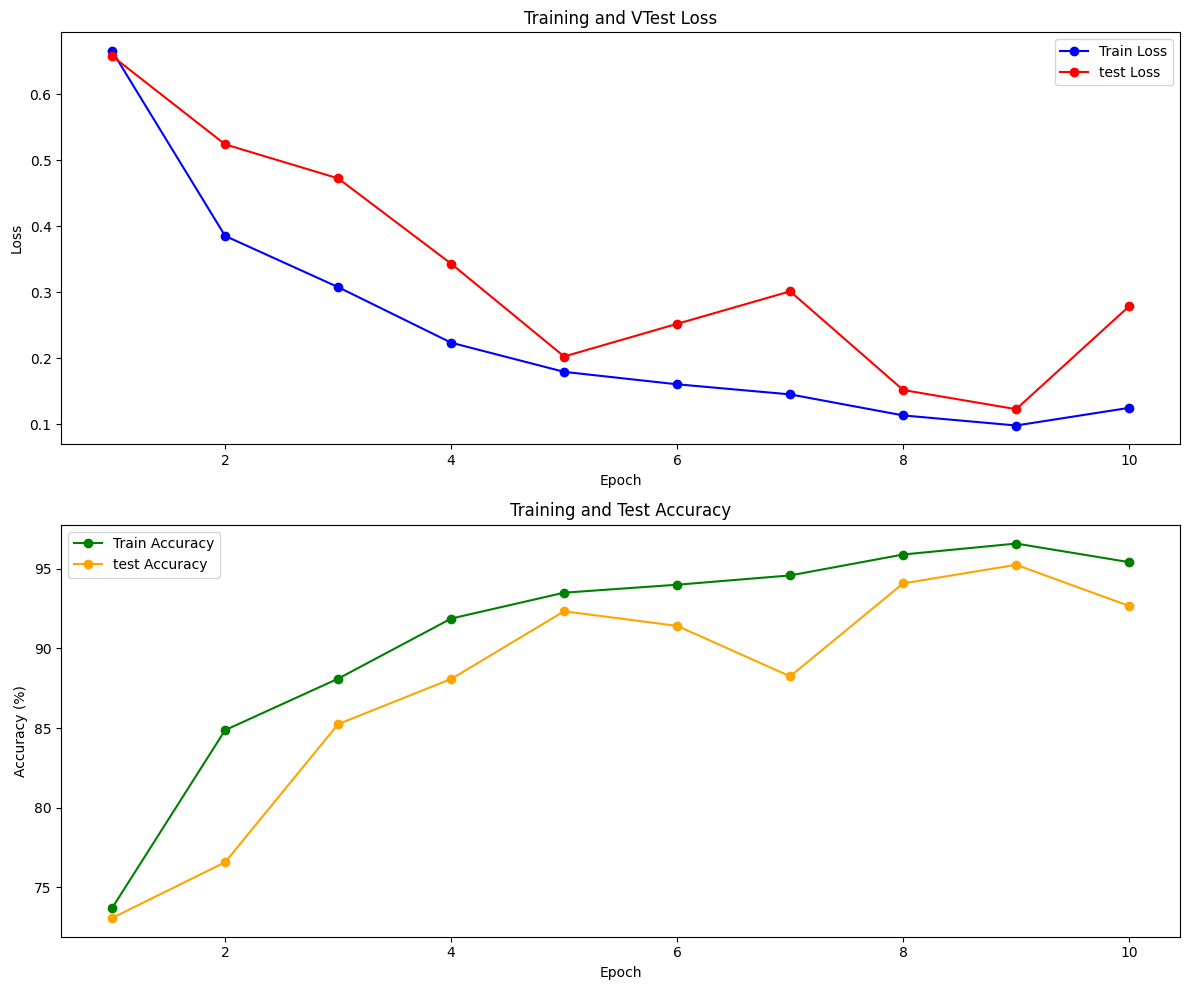

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training settings
num_epochs = 10
train_losses, train_accuracies=[],[]
test_losses, test_accuracies=[],[]

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= train_total
   
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # test
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_loss /= test_total
    
    scheduler.step(test_loss)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")




# torch.save(model.state_dict(), 'final_custom_resnet18.pth')
# print("Final model saved.")
# Save the final model and the features extracted by it
torch.save(model.features.state_dict(), 'final_feature_resnet18.pth')
print("Final feature model saved.")

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', color='r', label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='g', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', color='orange', label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


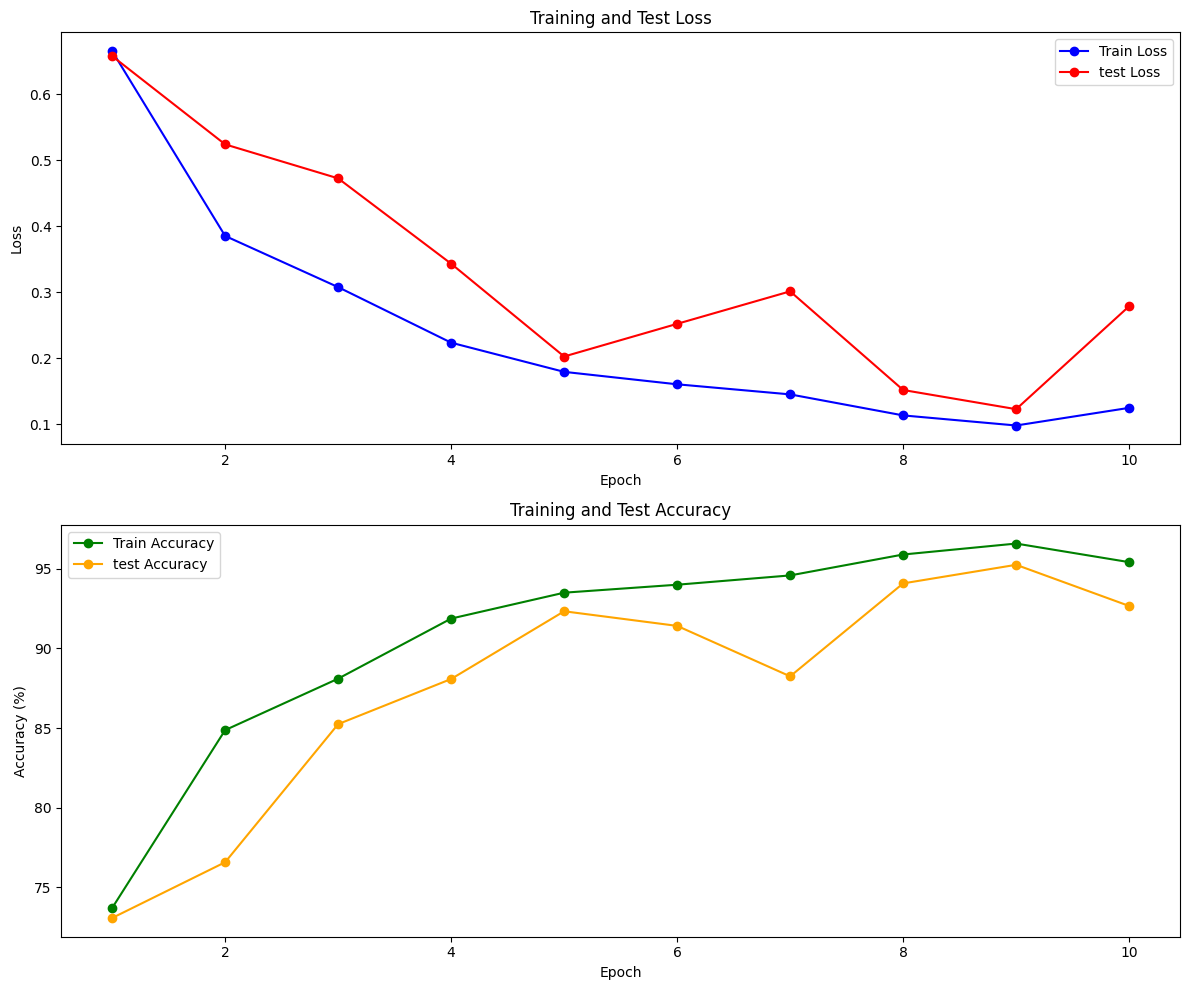

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', color='r', label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='g', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', color='orange', label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

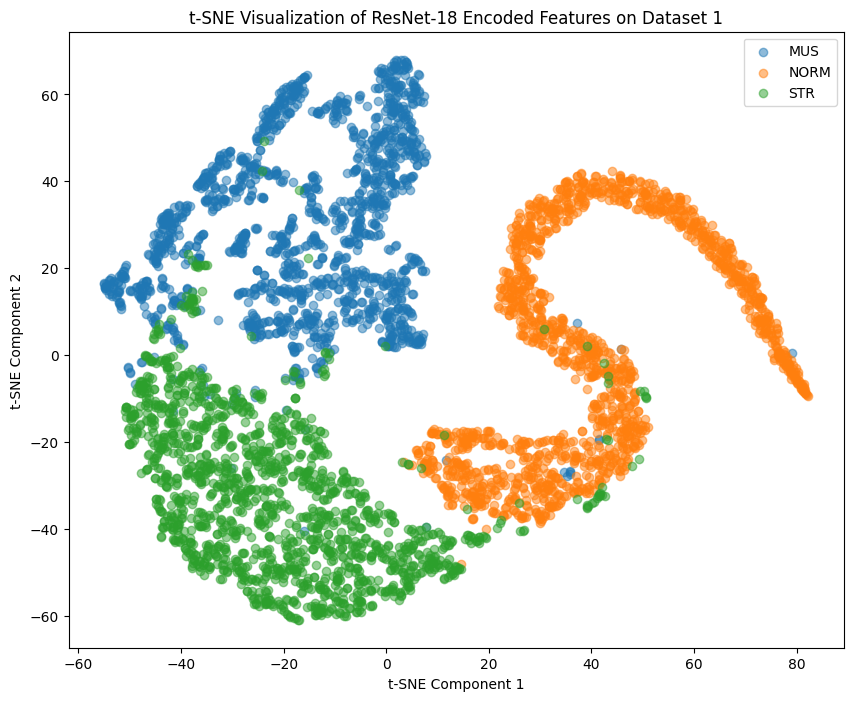

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Function to extract features using the model's encoder
def extract_features(data_loader, model):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)
            output = model.features(images)
            features.append(output.view(output.size(0), -1).cpu().numpy())
            labels.append(label.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


train_features, train_labels = extract_features(train_loader, model)
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(train_features)

# Plot t-SNE visualization of the encoded features
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    idx = train_labels == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=dataset.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of ResNet-18 Encoded Features on Dataset 1")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
